#Example Using n-APMO#

###Author:###
    Fernando Posada
    Quantum and Chemistry Group, Universidad Nacional de Colombia, 2015

In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np

import os
import sys
lib_path = os.path.abspath('../')
sys.path.append(lib_path)

##Molecule test##

This module is intented to load a molecular system.

* The stament ``molecule = MolecularSystem()`` will create a ``molecule`` object.
* ``molecule.add_atom`` will add a new atom in the molecule. You can add not only atoms, but particles as muons, positrons, etc.

In [2]:
from interfaces.molecular_system import MolecularSystem

In [3]:
molecule = MolecularSystem()
molecule.add_atom('H', [0.000000, 0.000000, 0.370000])
molecule.add_atom('H', [0.000000, 0.000000, -0.370000])
molecule.show()

Object: MolecularSystem
------------------------------------------------------------------
AtomicElement :  atoms   n. particles:  2
Symbol  n.    origin (Bohr)                            Basis-set 
H       1     [ 0.          0.          0.69919862]    none      
H       1     [ 0.          0.         -0.69919862]    none      
------------------------------------------------------------------
ElementaryParticle :  e-   n. particles:  2
Symbol  n.    origin (Bohr)                            Basis-set 
e-      1     [ 0.          0.          0.69919862]    none      
e-      1     [ 0.          0.         -0.69919862]    none      
------------------------------------------------------------------


##Numerical integration test##

In [4]:
import utilities.numerical_integration as nint

Computes the integral of f(x) by using Gauss-Chebyshev quadrature of second kind. Interval [-1,1]

Literature: Perez-Jorda, J., San-Fabian, E. & Moscardo, F. A simple, reliable and efficient scheme for automatic numerical integration. Comput. Phys. Commun. 70, 271-284 (1992).

Iterative method: The number of quadrature points increase until convergence is reached.
Return the integral value and the estimated error.

In [5]:
f0 = lambda x: np.exp(-6.793 * x * x) /(1.000001 - (x*x)) # exact : 0.762416793289 
nint.chebgauss_integrate(f0)

(0.76241679328946332, 4.8072656966269278e-14)

In [6]:
f1 = lambda x: 1/(x**4 + x**2 + 0.9) # exact : 1.582232963730
nint.chebgauss_integrate(f1)

(1.5822329637296715, 8.2156503822261584e-15)

##Radial Distribution##

In [7]:
import utilities.numerical_integration as nint

In Becke integration the molecules are modeled as spherical grids. Each Integral is discretized in that grid. The corresponding weights are calculated taking into account the size of the atom and the singularity in the nucleus. 

To build the grid one need to specify the quadrature points in the sphere (I will talk about it later) and the radial quadrature points.  Following the paper of Becke, 1988, and Jorda, 1992. I decided to use Gauss-Chebyshev points because those are given by analytical formulas.

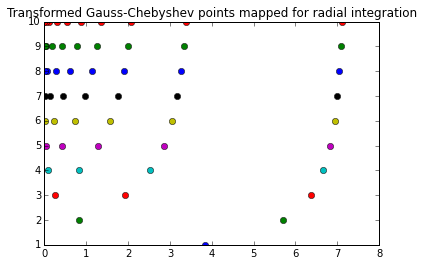

In [8]:
for p in range(1,11):
    rq = nint.chebgauss_rq(p, rescale=True)
    plt.title('Transformed Gauss-Chebyshev points mapped for radial integration')
    plt.plot(rq[:,1], (rq[:,1]*0)+p, 'o')


##Angular distribution##

In [9]:
import utilities.numerical_integration as nint
from scipy.spatial import ConvexHull

For Angular distribution (quadrature points on the sphere) I use the quadrature formulas published by Lebedev, 1980. In these formulas all spherical harmonics of order up to  ``l=35`` are integrated exactly.

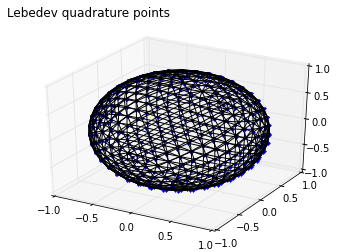

In [10]:
t, p, w = nint.lebedev_q(590) # lq is in spherical coordinates!

x = np.sin(t)*np.cos(p)
y = np.sin(t)*np.sin(p)
z = np.cos(t)

# plotting

points = np.array([x, y, z])
points = points.T

hull = ConvexHull(points)

edges = set()
for simplex in hull.simplices:
    edges.add(frozenset([simplex[0], simplex[1]]))
    edges.add(frozenset([simplex[1], simplex[2]]))
    edges.add(frozenset([simplex[2], simplex[0]]))
edges = [(a, b) for [a, b] in edges]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Lebedev quadrature points', loc='left')
ax.plot(x, y, z, '.')

for a, b in edges:
    p1 = hull.points[a]
    p2 = hull.points[b]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='black')

## Becke grids and weights ##

In [11]:
from interfaces.becke_grid import *
from utilities.constants import *

This algorithm is the implementation published in Becke, 1988.

### step function test:

The step function smooths the nuclear weights in the vecinity of other nuclei inside of the molecule. In the following plot it was tested the function with orders from 1 to 5. The order 3 is finally chosen for all calculations.

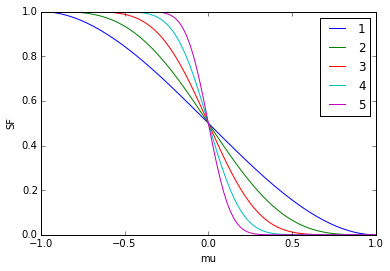

In [12]:
angularPoints = 590
radialPoints = 2

grid = BeckeGrid(radialPoints,angularPoints)
order = 5
mu = np.linspace(-1,1,100)
for k in range(1,order+1):
    plt.plot(mu, grid.step_function(k,mu), label=str(k))

plt.xlabel('mu')
plt.ylabel('SF')
plt.legend()

### Becke weights test

It is supposed that the sumatory of w(r) = 1. In the next calculation it can be seen that this is true for a H2 molecule were r = 0 means the center of the molecule.

In [13]:
def weights_helper(grid, atoms):
    
    wx = np.zeros([len(atoms),radialPoints*angularPoints])
    wy = np.zeros([len(atoms),radialPoints*angularPoints])
    wz = np.zeros([len(atoms),radialPoints*angularPoints])
    wp = np.zeros([len(atoms),radialPoints*angularPoints])
    r = np.zeros([3], dtype=np.float64)
    
    counter = 0
    for rp in range(grid.n_radial):
    
        x = grid.radial_abscissas[rp]
        rw = grid.radial_weights[rp]

        for ap in range(grid.n_angular):
        
            t = grid.angular_theta[ap]
            p = grid.angular_phi[ap]
            aw = grid.angular_weights[ap]

            for ia in range(len(atoms)):
            
                atom = atoms[ia]

                rm = atom.get('atomic_radii') * ANGSTROM_TO_BOHR

                if atom.get("atomic_number") != 1:
                    rm *= 0.5

                aux = (x + 1.0) * 0.5
                aux2 = aux * aux
                rad = -rm * np.log(1.0 - (aux2 * aux2))

                aux3 = np.sin(t)
                r[0] = rad * aux3 * np.cos(p)
                r[1] = rad * aux3 * np.sin(p)
                r[2] = rad * np.cos(t)

                r += atom.get("origin")
                
                wx[ia, counter] = r[0]
                wy[ia, counter] = r[1]
                wz[ia, counter] = r[2]
                
                pvor = grid.weight(r, ia, atoms)

                wp[ia, counter] = pvor
            # end ia
            counter +=1
        #end ap
    #end rp

    return wx, wy, wz, wp

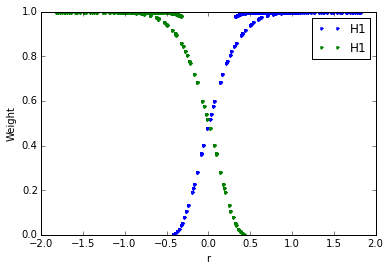

In [14]:
angularPoints = 590
radialPoints = 6

grid = BeckeGrid(radialPoints, angularPoints)
atoms = molecule.get('atoms')

wx, wy, wz, wp = weights_helper(grid, atoms)

# The following code is to print out some "repesentation" of the grids.
for ia in range(len(atoms)):
    plt.plot(wz[ia,:], wp[ia,:], '.', label='H1')
    
plt.xlabel('r')
plt.ylabel('Weight')
plt.legend()

In the following plot it is shown the spherical grids and its equivalent weight in the color scale. It can be seen that the value of the weigth changes with the proximity of another atom inside of the molecule. Even if the grids are overlaped the weight of the point r of atom A is zero in the proximity of atom B.

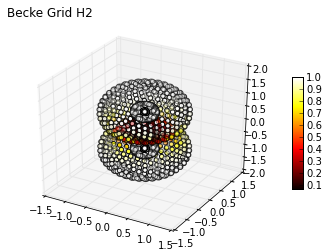

In [15]:
angularPoints = 590
radialPoints = 5

grid = BeckeGrid(radialPoints, angularPoints)
atoms = molecule.get('atoms')

wx, wy, wz, wp = weights_helper(grid, atoms)

fig_grids = plt.figure()
bx = fig_grids.add_subplot(111, projection='3d')
bx.set_title('Becke Grid H2', loc='left')

for ia in range(len(atoms)):
    aux = bx.scatter(wx[ia,:], wy[ia,:], wz[ia,:], c=wp[ia,:], cmap=plt.hot())
    
fig_grids.colorbar(aux, shrink=0.5, aspect=10)